In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from dosipy.utils.dataloader import load_antenna_el_properties
from dosipy.utils.viz import set_axes_equal

In [2]:
def sph2cart(r, theta, phi):
    x = r * np.cos(phi) * np.sin(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(theta)
    return x, y, z

In [3]:
def take_a_look(xt, yt, zt, xs, ys, zs):
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    ax.scatter(xt, yt, zt, s=15, color='k', depthshade=True)
    ax.plot(xs, ys, zs, 'k-')
    ax.set(xlabel='$x$ [mm]', ylabel='$y$ [mm]', zlabel='$z$ [mm]',
           xticks=[xs.min(), xt.min(), 0.0, xt.max(), xs.max()],
           yticks=[h, h/2, 0.0],
           zticks=[xs.min(), zt.min(), 0.0, zt.max(), xs.max()],
           xticklabels=[round(xs.min()*1000, 1), round(xt.min()*1000, 1), 0.0, round(xt.max()*1000, 1), round(xs.max()*1000, 1)],
           yticklabels=['$d$', '$d/2$', 0.0],
           zticklabels=[round(xs.min()*1000, 1), round(zt.min()*1000, 1), 0.0, round(zt.max()*1000, 1), round(xs.max()*1000, 1)],
          )
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.labelpad = 10
    ax.yaxis.labelpad = 10
    ax.zaxis.labelpad = 10
    ax.view_init(25, -45)
    fig.tight_layout()
    return fig, ax

In [4]:
# frequency
f = 6e9

# separation distance
h = -2.5 / 1000

# averaging surface
if f < 30:
    target_area = (0.02, 0.02)
else:
    target_area = (0.01, 0.01)
A = target_area[0] * target_area[1]
target_area_origin = (-target_area[0]/2, -target_area[1]/2)

# source
data = load_antenna_el_properties(f)
xs = data.x.to_numpy()
xs -= xs.max() / 2
ys = np.zeros_like(xs) + h
zs = np.zeros_like(xs)
Is = np.abs(data.ireal.to_numpy() + 1j * data.iimag.to_numpy())

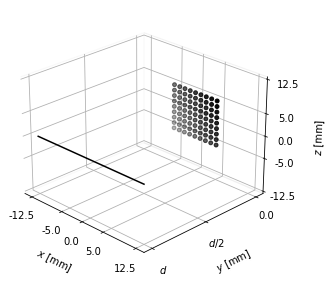

In [5]:
# planar target
N = 9
x = np.linspace(-target_area[0]/2, target_area[0]/2, N)
y = 0.0
z = np.linspace(-target_area[1]/2, target_area[1]/2, N)
Xt, Zt = np.meshgrid(x, z)
xt_pln = Xt.ravel()
yt_pln = np.zeros_like(xt_pln)
zt_pln = Zt.ravel()

fig, ax = take_a_look(xt_pln, yt_pln, zt_pln, xs, ys, zs);

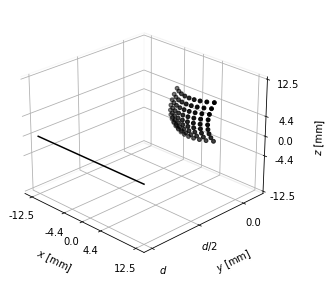

In [16]:
N = 151
theta = np.linspace(0, np.pi, N)
phi = np.linspace(0, -np.pi, N)
r = 0.0525
Theta, Phi = np.meshgrid(theta, phi)

x_sph, y_sph, z_sph = sph2cart(r, Theta.ravel(), Phi.ravel())
xyz_sph = np.c_[x_sph, y_sph, z_sph]
mask = np.where((xyz_sph[:, 0] > xt_pln.min())
                & (xyz_sph[:, 0] < xt_pln.max())
                & (xyz_sph[:, 2] > zt_pln.min())
                & (xyz_sph[:, 2] < xt_pln.max()))[0]
xt_sph = xyz_sph[mask, 0]
yt_sph = xyz_sph[mask, 1] - xyz_sph[mask, 1].min()
zt_sph = xyz_sph[mask, 2]

fig, ax = take_a_look(xt_sph, yt_sph, zt_sph, xs, ys, zs)